# Non supervised learning

## Autoencoders

Suppose we have only a set of unlabeled training examples $x_1,x_2,x_3, \dots $, where $x_i \in \Re^n$. 

An autoencoder neural network is an *unsupervised learning* algorithm that applies backpropagation and uses a loss function that is optimal when setting the target values to be equal to the inputs, $y_i=x_i$.

To build an autoencoder, you need three things: an **encoding function**, a **decoding function**, and a **distance function** between the amount of information loss between the compressed representation of your data and the decompressed representation.

<center>
<img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg" alt="" style="width: 700px;"/>
</center>

Two practical applications of autoencoders are data denoising, and dimensionality reduction for data visualization. In addition, it has shown to be an improvement over Matrix Factorization algorithms for Recommender Systems. 

With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

# Let's prepare our input data. 

In [45]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np

In [20]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


# Create a simple 1-hidden layer AE

Remember the steps:

 - build the model
 - compile
 - fit

In [39]:
# Autoencoder sequential
m = models.Sequential()
m.add(
m.add(layers.Dense(16, activation='elu'))
m.add(layers.Dense(512, activation='sigmoid'))

m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_23 (Dense)             (None, 16)                8208      
_________________________________________________________________
dense_24 (Dense)             (None, 512)               8704      
Total params: 418,832
Trainable params: 418,832
Non-trainable params: 0
_________________________________________________________________


In [40]:
m.compile(optimizer=optimizers.rmsprop(), loss=losses.mse)

In [41]:
m.fit(x_train, batch_size=512, epochs=200, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples


IndexError: list index out of range

In [83]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoder_layer = Dense(encoding_dim, activation='relu')
encoded = encoder_layer(input_img)
# "decoded" is the lossy reconstruction of the input
decoder_layer = Dense(784, activation='sigmoid')
decoded = decoder_layer(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [84]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_45 (Dense)             (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [85]:
autoencoder.compile(optimizer=optimizers.Adam(), loss=losses.binary_crossentropy)

In [86]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.2768 - val_loss: 0.1884
Epoch 2/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.1701 - val_loss: 0.1525
Epoch 3/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.1434 - val_loss: 0.1330
Epoch 4/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.1279 - val_loss: 0.1208
Epoch 5/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1176 - val_loss: 0.1121
Epoch 6/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.1103 - val_loss: 0.1061
Epoch 7/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.1052 - val_loss: 0.1019
Epoch 8/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1016 - val_loss: 0.0989
Epoch 9/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.0991 - val_loss: 0.0968
Epoch

## Predict some images

Note that here `predict` does not mean to predict a label, but rather a forward pass through the network (i.e. inference)

In [87]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

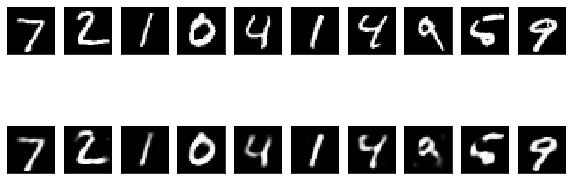

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 10  # how many digits we will display
plt.figure(figsize=(10, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Note that we can also create a separate encoder model and a separate decoder model

In [91]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [92]:
encoded_imgs.shape

(10000, 32)

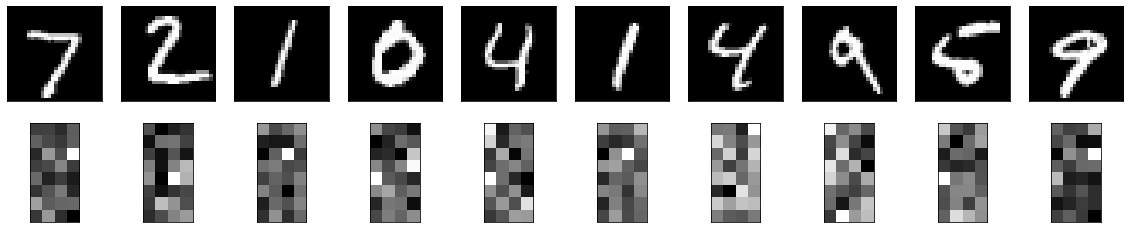

In [93]:
#Plot results
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(8,4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Try doing the same with larger hidden layers

In [105]:
# this is the size of our encoded representations
encoding_dim = 36  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoder_layer1 = Dense(4*encoding_dim, activation='relu')
encoded_1 = encoder_layer1(input_img)
encoder_layer2 = Dense(encoding_dim, activation='relu')
encoded_2 = encoder_layer2(encoded_1)
# "decoded" is the lossy reconstruction of the input
decoder_layer = Dense(784, activation='sigmoid')
decoded = decoder_layer(encoded_2)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder_1 = Model(input_img, encoded_1)
encoder_2 = Model(input_img, encoded_2)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [106]:
autoencoder.compile(optimizer=optimizers.rmsprop(), loss=losses.binary_crossentropy)

In [107]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.2197 - val_loss: 0.1574
Epoch 2/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.1432 - val_loss: 0.1286
Epoch 3/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.1248 - val_loss: 0.1163
Epoch 4/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.1157 - val_loss: 0.1121
Epoch 5/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.1100 - val_loss: 0.1100
Epoch 6/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.1062 - val_loss: 0.1019
Epoch 7/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.1033 - val_loss: 0.1104
Epoch 8/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.1011 - val_loss: 0.1012
Epoch 9/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.0994 - val_loss: 0.0972
Epoch

In [102]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs_1 = encoder_1.predict(x_test)
encoded_imgs_2 = encoder_2.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs_2)

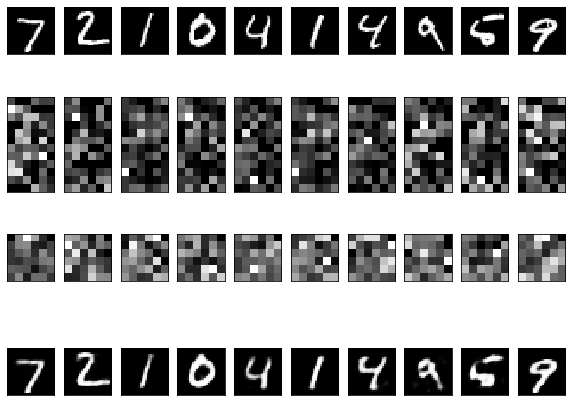

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 10  # how many digits we will display
plt.figure(figsize=(10, 8))
for i in range(n):
    # display original
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display hidden 
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(encoded_imgs_1[i].reshape(12,6))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display hidden 
    ax = plt.subplot(4, n, i + n + n +1)
    plt.imshow(encoded_imgs_2[i].reshape(6,6))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(4, n, i + 3*n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Adding a sparsity constraint on the encoded representations

In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. 

In Keras, this can be done by adding an ``activity_regularizer`` to our Dense layer:

In [130]:
from keras import regularizers

In [141]:
# Autoencoder with L1 activity regularizer
# this is the size of our encoded representations
autoencoder.reset_states()
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoder_layer = Dense(encoding_dim, activation='relu',
                     activity_regularizer=regularizers.l1(0.1))
encoded = encoder_layer(input_img)
# "decoded" is the lossy reconstruction of the input
decoder_layer = Dense(784, activation='sigmoid')
decoded = decoder_layer(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [142]:
autoencoder.compile(optimizer=optimizers.rmsprop(), loss=losses.binary_crossentropy)

In [143]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 43us/step - loss: 1.8569 - val_loss: 0.6112
Epoch 2/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.5765 - val_loss: 0.5446
Epoch 3/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.5153 - val_loss: 0.4890
Epoch 4/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.4646 - val_loss: 0.4431
Epoch 5/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.4230 - val_loss: 0.4056
Epoch 6/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.3891 - val_loss: 0.3752
Epoch 7/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.3619 - val_loss: 0.3508
Epoch 8/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.3401 - val_loss: 0.3314
Epoch 9/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.3229 - val_loss: 0.3160
Epoch

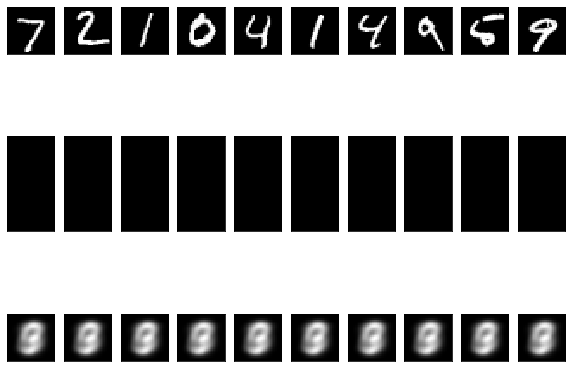

In [146]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

import matplotlib.pyplot as plt
%matplotlib inline

n = 10  # how many digits we will display
plt.figure(figsize=(10, 8))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display hidden 
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(8,4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 2*n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [145]:
decoded_imgs[1]

array([4.61250638e-05, 4.61278796e-05, 4.61232157e-05, 4.61203999e-05,
       4.61182462e-05, 4.61235650e-05, 4.61220698e-05, 4.61196105e-05,
       4.61196105e-05, 4.61200943e-05, 4.61213676e-05, 4.61223790e-05,
       5.26671392e-05, 6.67151253e-05, 5.59318942e-05, 4.64686782e-05,
       4.61221607e-05, 4.61188174e-05, 4.61190793e-05, 4.61225100e-05,
       4.61215895e-05, 4.61188174e-05, 4.61242744e-05, 4.61225973e-05,
       4.61271302e-05, 4.61161799e-05, 4.61238342e-05, 4.61225100e-05,
       4.61231248e-05, 4.61212803e-05, 4.61246673e-05, 4.61228628e-05,
       4.68799044e-05, 4.91554274e-05, 7.73883730e-05, 1.23476260e-04,
       1.80796589e-04, 2.53384816e-04, 4.40074655e-04, 5.85378963e-04,
       6.36372250e-04, 6.46556902e-04, 6.95070426e-04, 6.27373403e-04,
       6.72283291e-04, 5.57002088e-04, 3.62908555e-04, 2.70019751e-04,
       2.12033483e-04, 1.09593297e-04, 7.59932664e-05, 5.57283529e-05,
       4.61232994e-05, 4.61247109e-05, 4.61192139e-05, 4.61244017e-05,
      

## Going deep

Compare the loss with the shallow case. Does it get any better?

In [ ]:
# Try 784-128-64-32-64-128-784 architecture with relu activations and sigmoid in the last layer


## Example: Image denoising

It's simple: we will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

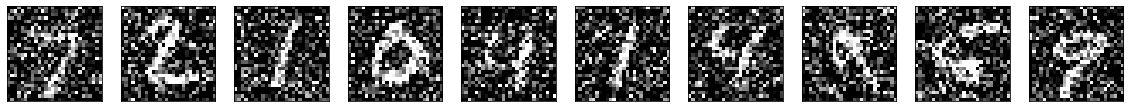

In [129]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 784))
x_test = np.reshape(x_test, (len(x_test), 784))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#model


In [ ]:
#display original, noisy and reconstruction


## Variational Autoencoders

In [ ]:
from IPython.display import display_html
def restartkernel():
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
restartkernel()    

In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy, mse

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K

A variational autoencoder is an autoencoder that adds probabilistic constraints on the representations being learned. 

> When using probabilistic models, **compressed representation** is called **latent variable model**. 

So, instead of learning a function this model is learning a probabilistic distribution function that models your data.

> Why? Standard autoencoders are not suited to work as a generative model. If you pick a random value for your decoder you won't get necessarily a good reconstruction: the value can far away from any previous value the network has seen before! That's why attaching a probabilistic model to the compressed representation is a good idea! 

For sake of simplicity, let's use a standard normal distribution to define the distribution of inputs ($\mathbf V$) the decoder will receive. 

The architecture of a variational autoencoder (VAE) is thus:

<center>
<img src="http://ijdykeman.github.io/assets/cvae_figures/ae_diagram.svg" alt="" style="width: 300px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

We want the decoder to take any point taken from a standard normal distribution to return a reasonable element of our dataset:

<center>
<img src="http://ijdykeman.github.io/assets/cvae_figures/vae_decoder_diagram.svg" alt="" style="width: 500px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

Let's consider the encoder role in this architecture. 

In a traditional autoencoder, the encoder model takes a sample from data and returns a single point in the latent space, which is then passed to the decoder.

> What information is encoded in the latent space?

In VAE the encoder instead produces (the parameters of) a probability distribution in the latent space:

<center>
<img src="http://ijdykeman.github.io/assets/cvae_figures/encoder_vae_diagram.svg" alt="" style="width: 500px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

These distributions are (non standard) Gaussians of the same dimensionality as the latent space. 

First, let’s implement the encoder net, which takes input $X$ and outputs two things: $\mu(X)$ and $\Sigma(X)$, the parameters of the Gaussian. Our encoder will be a neural net with one hidden layer. 

Our latent variable is two dimensional, so that we could easily visualize it.

Load data with labels for visualization purposes

In [ ]:
# MNIST dataset


In [ ]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 100
latent_dim = 2
epochs = 25
epsilon_std=0.05 # This parameter is the most critical one, as it determines the sampling

Up to now we have an encoder that takes images and produce (the parameters of) a pdf in the latent space.  The decoder takes points in the latent space and return reconstructions.

How do we connect both models? By sampling from the produced distribution!


<center>
<img src="http://ijdykeman.github.io/assets/cvae_figures/vae_diagram.svg" alt="" style="width: 400px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

To this end we will implement a *random variate reparameterisation*: the substitution of a random variable by a deterministic transformation of a simpler random variable.

There are several methods by which non-uniform random numbers, or random variates, can be generated. The most popular methods are the **one-liners**, which give us the simple tools to generate random variates in one line of code, following the classic paper by Luc Devroye (Luc Devroye, Random variate generation in one line of code, Proceedings of the 28th conference on Winter simulation, 1996).

In the case of a Gaussian, we can use the following algorithm:
+ Generate $\epsilon \sim \mathcal{N}(0;1)$.
+ Compute a sample from $\mathcal{N}(\mu; RR^T)$ as $\mu + R \epsilon$.

In [ ]:
#Implement the above formula

def sampling(args):
    return 

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

Now we can create the decoder net:

Lastly, from this model, we can do three things: reconstruct inputs, encode inputs into latent variables, and generate data from latent variable. 

In order to be coherent with our previous definitions, we must assure that points sampled fron the latent space fit a standard normal distribition, but the encoder is producing non standard normal distributions. So, we must add a constraint for getting something like this:

<center>
<img src="http://ijdykeman.github.io/assets/cvae_figures/kl_divergence_diagram.svg" alt="" style="width: 700px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

In order to impose this constraint in the loss function by using the Kullback-Leibler divergence.

> The Kullback–Leibler divergence is a measure of how one probability distribution diverges from a second expected probability distribution. 
For discrete probability distributions $P$ and $Q$, the Kullback–Leibler divergence from $Q$ to $P$ is defined to be
$$ D_{\mathrm {KL} }(P\|Q)=\sum _{i}P(i)\,\log {\frac {P(i)}{Q(i)}}. $$

The rest of the loss function must take into account the "reconstruction" error.

In [ ]:
from keras.losses import mse, binary_crossentropy
def vae_loss(y_true, y_pred):
    """ 
    Calculate loss = reconstruction loss + 
    KL loss for each data in minibatch 
    """
    return 

### Training a VAE

How do we train a model that have a sampling step? 

<center>
<img src="images/vae_sampling.png" alt="" style="width: 800px;"/> 
</center>

In fact this is not a problem! By using the *one-linear* method for sampling we have expressed the latent distribution in a way that its parameters are factored out of the parameters of the random variable so that backpropagation can be used to find the optimal parameters of the latent distribution. For this reason this method is called *reparametrization trick*.

By using this trick we can train end-to-end a VAE with backpropagation.

## Visualization

# Excercises

* Play with the smapling parameter epsilon_std
* Create a VAE model with several layers (deep AE)
* Change the reconstruction loss to mse or mae

## Deeper network

In [ ]:
from IPython.display import display_html
def restartkernel():
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
restartkernel()    

In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K

In [ ]:
# MNIST dataset


In [ ]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = [512, 128, 32]
batch_size = 100
latent_dim = 2
epochs = 30
epsilon_std = 1e-3 # This parameter is the most critical one, as it determines the sampling

In [ ]:
# VAE model


In [ ]:
# Predict


In [ ]:
# Plot results


## mse error

In [ ]:
from IPython.display import display_html
def restartkernel():
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
restartkernel()    

In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy, mse

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K

In [ ]:
# MNIST dataset


In [ ]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 100
latent_dim = 2
epochs = 25
epsilon_std = 5e-4



In [ ]:
# VAE model


In [ ]:
# Predict


In [ ]:
#Plot results
